### Import Dataset

In [ ]:
import keras, os
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.layers import Dropout
import tensorflow as tf

In [ ]:
train_gen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, rotation_range=15, horizontal_flip = True, shear_range = 0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
path = '/pneumonia_covid19_classification/dataset_balanced'
train_data = train_gen.flow_from_directory(path + '/train', target_size=(299,299),batch_size=64,class_mode='categorical',shuffle=True)
test_data = test_gen.flow_from_directory(path +'/test', target_size=(299,299),batch_size=64,class_mode='categorical',shuffle=True)

Found 1818 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


### Convert Data Label

In [ ]:
from keras.utils.np_utils import to_categorical 
print(train_data.class_indices)
num_classes = len(train_data.class_indices)
train_labels = train_data.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
print(test_data.class_indices)
num_classes = len(test_data.class_indices)
test_labels = test_data.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


### Create InceptionResNetV2 Model

In [ ]:
from keras.applications import Xception
from keras.optimizers import Adam

In [ ]:
def create_Xception():
  xception = Xception(input_shape=(299, 299, 3), weights='imagenet', include_top=False)
  #freeze all layers
  for layer in xception.layers:
    layer.trainable = False
  x = xception.output
  x = AveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(64,activation='relu')(x)
  x = Dropout(0.3)(x)
  final_layer = Dense(3,activation='softmax')(x)
  model = Model(inputs=xception.input, outputs=final_layer)
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
model = create_Xception()

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
incepRes_model = model.fit(train_data, validation_data=test_data, 
                      epochs=initial_epoch, 
                      steps_per_epoch=None, 
                      validation_steps=None,
                      callbacks=my_callbacks)

Epoch 1/15
29/29 [==============================] - 1792s 62s/step - loss: 0.9988 - accuracy: 0.8174 - val_loss: 0.2424 - val_accuracy: 0.9062
Epoch 2/15
29/29 [==============================] - 117s 4s/step - loss: 0.2029 - accuracy: 0.9312 - val_loss: 0.1633 - val_accuracy: 0.9396
Epoch 3/15
29/29 [==============================] - 115s 4s/step - loss: 0.1644 - accuracy: 0.9400 - val_loss: 0.1407 - val_accuracy: 0.9375
Epoch 4/15
29/29 [==============================] - 113s 4s/step - loss: 0.1470 - accuracy: 0.9543 - val_loss: 0.1930 - val_accuracy: 0.9333
Epoch 5/15
29/29 [==============================] - 115s 4s/step - loss: 0.1348 - accuracy: 0.9593 - val_loss: 0.2304 - val_accuracy: 0.9229
Epoch 6/15
29/29 [==============================] - 115s 4s/step - loss: 0.1325 - accuracy: 0.9505 - val_loss: 0.1349 - val_accuracy: 0.9521
Epoch 7/15
29/29 [==============================] - 115s 4s/step - loss: 0.1235 - accuracy: 0.9565 - val_loss: 0.1744 - val_accuracy: 0.9458
Epoch 8/15


### Load ModelCheckpoint

In [ ]:
model.load_weights('/pneumonia_covid19_classification/Xception/logs/V1')

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
num_of_test_samples = 480 
batch_size = 64
test_data.shuffle = False
Y_pred = model.predict(test_data, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
# from time import time
# infer_time = []
# t0 = time()
# yy_pred = model.predict(im.reshape((1,299,299,3)))
# infer_time.append((time()-t0)*1000)
# print('average time is {} ms'.format(np.average(np.asarray(infer_time))))
# print(yy_pred)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(test_data.classes, y_pred, target_names=target_names))
print(f'Accuracy: {accuracy_score(test_data.classes, y_pred)}')

Confusion Matrix
[[160   0   0]
 [  0 156   4]
 [  2  10 148]]
Classification Report
              precision    recall  f1-score   support

     COVID19       0.99      1.00      0.99       160
      NORMAL       0.94      0.97      0.96       160
   PNEUMONIA       0.97      0.93      0.95       160

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480

Accuracy: 0.9666666666666667


### Fine Tuning

In [ ]:
#unfreeze all layers
model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(model.layers))
for i in range(len(model.layers)):
  print(f"{i}:{model.layers[i].name}")

Number of layers in the base model:  136
0:input_1
1:block1_conv1
2:block1_conv1_bn
3:block1_conv1_act
4:block1_conv2
5:block1_conv2_bn
6:block1_conv2_act
7:block2_sepconv1
8:block2_sepconv1_bn
9:block2_sepconv2_act
10:block2_sepconv2
11:block2_sepconv2_bn
12:conv2d
13:block2_pool
14:batch_normalization
15:add
16:block3_sepconv1_act
17:block3_sepconv1
18:block3_sepconv1_bn
19:block3_sepconv2_act
20:block3_sepconv2
21:block3_sepconv2_bn
22:conv2d_1
23:block3_pool
24:batch_normalization_1
25:add_1
26:block4_sepconv1_act
27:block4_sepconv1
28:block4_sepconv1_bn
29:block4_sepconv2_act
30:block4_sepconv2
31:block4_sepconv2_bn
32:conv2d_2
33:block4_pool
34:batch_normalization_2
35:add_2
36:block5_sepconv1_act
37:block5_sepconv1
38:block5_sepconv1_bn
39:block5_sepconv2_act
40:block5_sepconv2
41:block5_sepconv2_bn
42:block5_sepconv3_act
43:block5_sepconv3
44:block5_sepconv3_bn
45:add_3
46:block6_sepconv1_act
47:block6_sepconv1
48:block6_sepconv1_bn
49:block6_sepconv2_act
50:block6_sepconv2
51:

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 86

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Let's take a look at the base model architecture
model.summary()
len(model.trainable_variables)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

59

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epoch + fine_tune_epochs
# print(incepRes_model.epoch)

Callbacks - Finetune

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger

checkpoint_filepath = '/pneumonia_covid19_classification/Xception/logs_finetune/V1_finetune'
log_dir = '/pneumonia_covid19_classification/Xception/logs_finetune'

my_fine_callbacks = [
    ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True),
]

In [ ]:
incepRes_model_fine = model.fit(train_data, validation_data=test_data, 
                      epochs=total_epochs, 
                      steps_per_epoch=None, 
                      validation_steps=None,
                      initial_epoch=incepRes_model.epoch[-1] + 1,
                      callbacks=my_fine_callbacks)

Epoch 16/30
29/29 [==============================] - 127s 4s/step - loss: 0.2850 - accuracy: 0.9274 - val_loss: 0.2166 - val_accuracy: 0.9229
Epoch 17/30
29/29 [==============================] - 126s 4s/step - loss: 0.1141 - accuracy: 0.9615 - val_loss: 0.1554 - val_accuracy: 0.9396
Epoch 18/30
29/29 [==============================] - 127s 4s/step - loss: 0.0889 - accuracy: 0.9736 - val_loss: 0.1214 - val_accuracy: 0.9563
Epoch 19/30
29/29 [==============================] - 126s 4s/step - loss: 0.0637 - accuracy: 0.9741 - val_loss: 0.1192 - val_accuracy: 0.9563
Epoch 20/30
29/29 [==============================] - 125s 4s/step - loss: 0.0613 - accuracy: 0.9796 - val_loss: 0.1450 - val_accuracy: 0.9479
Epoch 21/30
29/29 [==============================] - 124s 4s/step - loss: 0.0481 - accuracy: 0.9846 - val_loss: 0.1756 - val_accuracy: 0.9375
Epoch 22/30
29/29 [==============================] - 125s 4s/step - loss: 0.0339 - accuracy: 0.9884 - val_loss: 0.1756 - val_accuracy: 0.9479
Epoch 

### Confusion Matrix (FineTune)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
model.load_weights('/pneumonia_covid19_classification/Xception/logs_finetune/V1_finetune')

In [ ]:
num_of_test_samples = 480
batch_size = 64
test_data.shuffle = False
Y_pred = model.predict_generator(test_data, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(test_data.classes, y_pred, target_names=target_names))
print(f'Accuracy: {accuracy_score(test_data.classes, y_pred)}')

Confusion Matrix
[[159   1   0]
 [  0 158   2]
 [  2   8 150]]
Classification Report
              precision    recall  f1-score   support

     COVID19       0.99      0.99      0.99       160
      NORMAL       0.95      0.99      0.97       160
   PNEUMONIA       0.99      0.94      0.96       160

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480

Accuracy: 0.9729166666666667


In [ ]:
model.save('/pneumonia_covid19_classification/Xception/XceptionSavedModel')

INFO:tensorflow:Assets written to: /content/drive/My Drive/FYP/Xception/XceptionSavedModel/assets


### Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
acc1 = incepRes_model.history['accuracy']
acc = acc1 + incepRes_model_fine.history['accuracy'][1:]
val_acc1 = incepRes_model.history['val_accuracy']
val_acc = val_acc1 + incepRes_model_fine.history['val_accuracy'][1:]

loss1 = incepRes_model.history['loss']
loss = loss1 + incepRes_model_fine.history['loss'][1:]
val_loss1 = incepRes_model.history['val_loss']
val_loss = val_loss1 + incepRes_model_fine.history['val_loss'][1:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Unrecognized location 'middle right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if sys.path[0] == '':


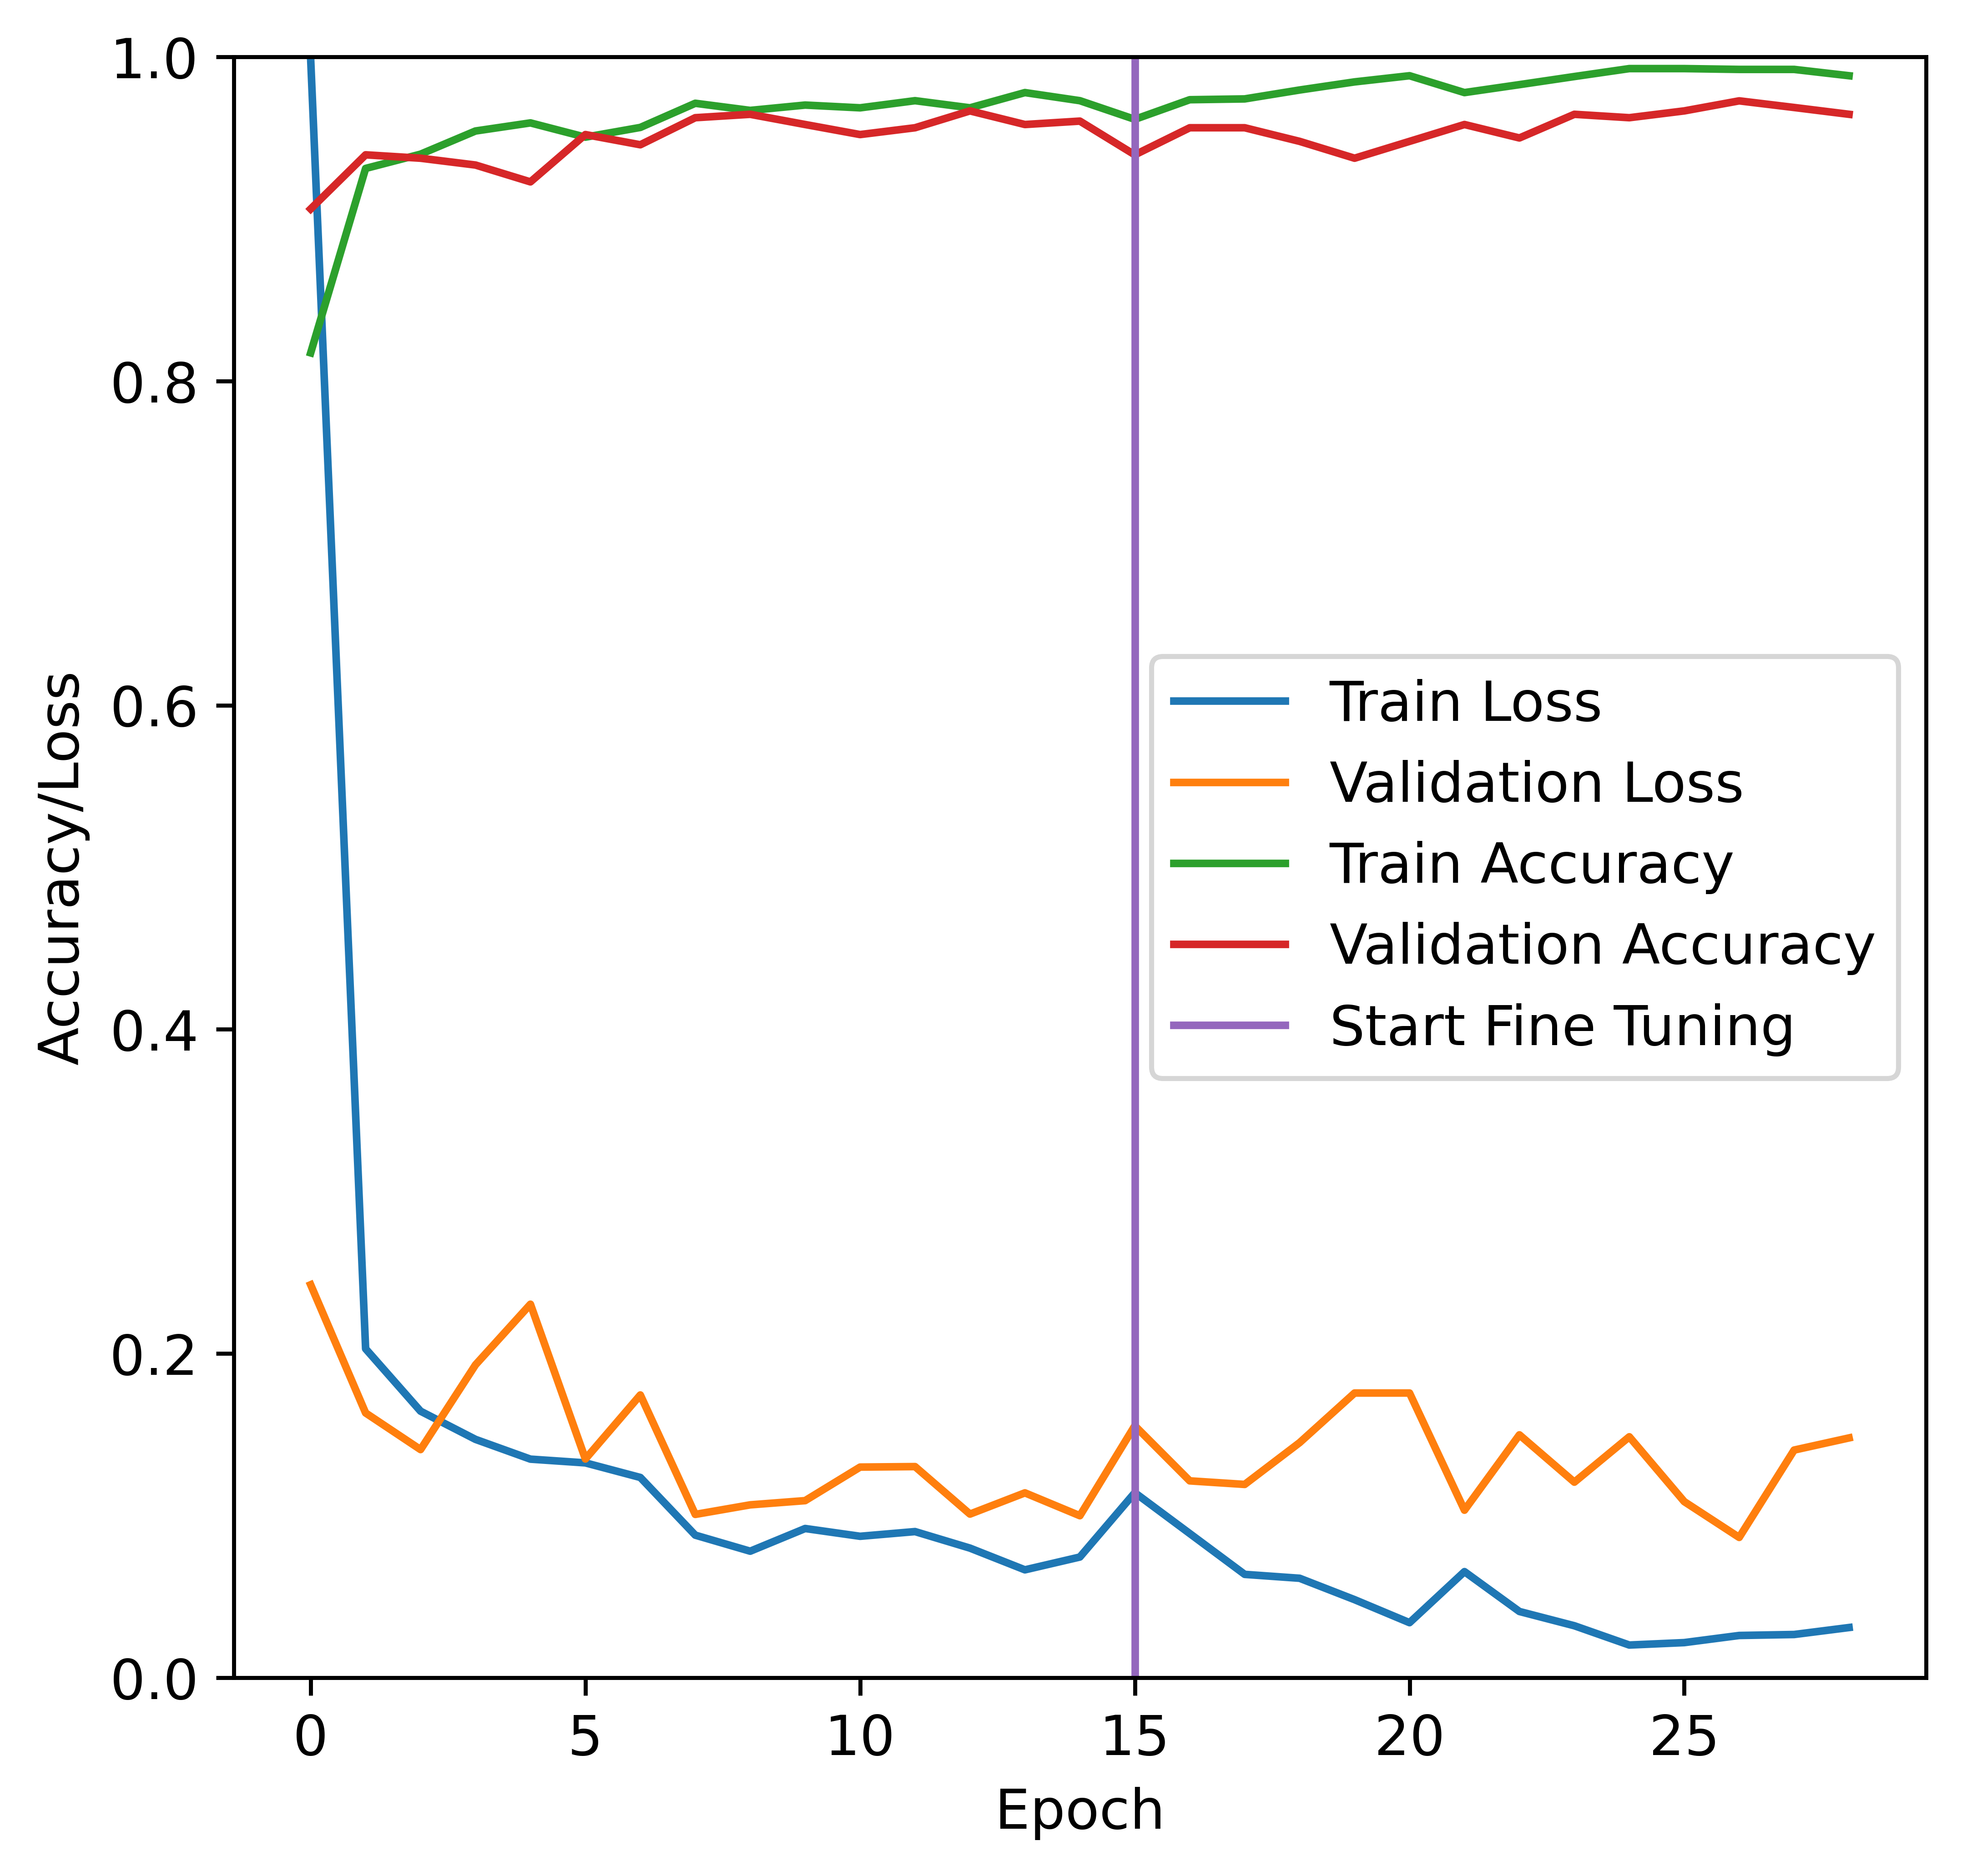

In [ ]:
plt.figure(figsize=(6,5.9), dpi=800)
plt.rcParams.update({'font.size': 11})
plt.plot(loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.plot(acc, label = 'Train Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0, 1.0])
# plt.plot([initial_epoch-1,initial_epoch],plt.ylim(), label='Start Fine Tuning')
initial_epoch = 15
plt.plot([initial_epoch,initial_epoch],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='middle right')
#plt.title('Model Loss and Accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()